# Problem 1: Basics of Neural Networks
* <b>Learning Objective:</b> In this problem, you are asked to implement a basic multi-layer fully connected neural network from scratch, including forward and backward passes of certain essential layers, to perform an image classification task on the CIFAR100 dataset. You need to implement essential functions in different indicated python files under directory `lib`.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> You are asked to implement the forward passes and backward passes for standard layers and loss functions, various widely-used optimizers, and part of the training procedure. And finally we want you to train a network from scratch on your own. Also, there are inline questions you need to answer. See `README.md` to set up your environment.

In [135]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.datasets import *
from lib.mlp.train import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data (CIFAR-100 with 20 superclasses)

In this homework, we will be classifying images from the CIFAR-100 dataset into the 20 superclasses. More information about the CIFAR-100 dataset and the 20 superclasses can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

Download the CIFAR-100 data files [here](https://drive.google.com/drive/folders/1imXxTnpkMbWEe41pkAGNt_JMTXECDSaW?usp=share_link), and save the `.mat` files to the `data/cifar100` directory.

Load the dataset.

In [136]:
data = CIFAR100_data('data/cifar100/')
for k, v in data.items():
    if type(v) == np.ndarray:
        print ("Name: {} Shape: {}, {}".format(k, v.shape, type(v)))
    else:
        print("{}: {}".format(k, v))
label_names = data['label_names']
mean_image = data['mean_image'][0]
std_image = data['std_image'][0]

Name: data_train Shape: (40000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_train Shape: (40000,), <class 'numpy.ndarray'>
Name: data_val Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_val Shape: (10000,), <class 'numpy.ndarray'>
Name: data_test Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_test Shape: (10000,), <class 'numpy.ndarray'>
label_names: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Name: mean_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>
Name: std_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>


## Implement Standard Layers
You will now implement all the following standard layers commonly seen in a fully connected neural network (aka multi-layer perceptron, MLP). Please refer to the file `lib/mlp/layer_utils.py`. Take a look at each class skeleton, and we will walk you through the network layer by layer. We provide results of some examples we pre-computed for you for checking the forward pass, and also the gradient checking for the backward pass.

## FC Forward [2pt]
In the class skeleton `flatten` and `fc` in `lib/mlp/layer_utils.py`, please complete the forward pass in function `forward`. The input to the `fc` layer may not be of dimension (batch size, features size), it could be an image or any higher dimensional data. We want to convert the input to have a shape of (batch size, features size). Make sure that you handle this dimensionality issue. 

In [137]:
%reload_ext autoreload

# Test the fc forward function
input_bz = 3 # batch size
input_dim = (7, 6, 4)
output_dim = 4

input_size = input_bz * np.prod(input_dim)
weight_size = output_dim * np.prod(input_dim)

flatten_layer = flatten(name="flatten_test")
single_fc = fc(np.prod(input_dim), output_dim, init_scale=0.02, name="fc_test")

x = np.linspace(-0.1, 0.4, num=input_size).reshape(input_bz, *input_dim)
w = np.linspace(-0.2, 0.2, num=weight_size).reshape(np.prod(input_dim), output_dim)
b = np.linspace(-0.3, 0.3, num=output_dim)

single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

out = single_fc.forward(flatten_layer.forward(x))

correct_out = np.array([[0.63910291, 0.83740057, 1.03569824, 1.23399591],
                        [0.61401587, 0.82903823, 1.04406058, 1.25908294],
                        [0.58892884, 0.82067589, 1.05242293, 1.28416997]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Difference:  4.0260162945880345e-09


## FC Backward [2pt]
Please complete the function `backward` as the backward pass of the `flatten` and `fc` layers. Follow the instructions in the comments to store gradients into the predefined dictionaries in the attributes of the class. Parameters of the layer are also stored in the predefined dictionary.

In [142]:
%reload_ext autoreload

# Test the fc backward function
inp = np.random.randn(15, 2, 2, 3)
w = np.random.randn(12, 15)
b = np.random.randn(15)
dout = np.random.randn(15, 15)

flatten_layer = flatten(name="flatten_test")
x = flatten_layer.forward(inp)
single_fc = fc(np.prod(x.shape[1:]), 15, init_scale=5e-2, name="fc_test")
single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

dx_num = eval_numerical_gradient_array(lambda x: single_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_fc.forward(x), b, dout)

out = single_fc.forward(x)
dx = single_fc.backward(dout)
dw = single_fc.grads[single_fc.w_name]
db = single_fc.grads[single_fc.b_name]
dinp = flatten_layer.backward(dx)

# The error should be around 1e-9
print("dx Error: ", rel_error(dx_num, dx))
# The errors should be around 1e-10
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dinp Shape: ", dinp.shape, inp.shape)

dx Error:  4.854732375235008e-09
dw Error:  1.7348331767878167e-10
db Error:  1.6664509266832546e-10
dinp Shape:  (15, 2, 2, 3) (15, 2, 2, 3)


## GeLU Forward [2pt]
In the class skeleton `gelu` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.

GeLU is a smooth version of ReLU and it's used in pre-training LLMs such as GPT-3 and BERT. 

$$
\mathrm{GeLU}(x) = x \Phi(x) \approx 0.5x(1+\tanh(\sqrt{2/\pi}(x+0.044715x^3)))
$$

Where $\Phi(x)$ is the CDF for standard Gaussian random variables.  You should use the approximate version to compute forward and backward pass.

In [5]:
%reload_ext autoreload

# Test the leaky_relu forward function
x = np.linspace(-1.5, 1.5, num=12).reshape(3, 4)
gelu_f = gelu(name="gelu_f")

out = gelu_f.forward(x)
correct_out = np.array([[-0.10042842, -0.13504766, -0.16231757, -0.1689214 ],
                        [-0.13960493, -0.06078651,  0.07557713,  0.26948598],
                        [ 0.51289678,  0.79222788,  1.09222506,  1.39957158]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Difference:  1.8037541876132445e-08


## GeLU Backward [2pt]
Please complete the `backward` pass of the class `gelu`. 

In [6]:
%reload_ext autoreload

# Test the relu backward function
x = np.random.randn(15, 15)
dout = np.random.randn(*x.shape)
gelu_b = gelu(name="gelu_b")

dx_num = eval_numerical_gradient_array(lambda x: gelu_b.forward(x), x, dout)

out = gelu_b.forward(x)
dx = gelu_b.backward(dout)

# The error should not be larger than 1e-4, since we are using an approximate version of GeLU activation. 
print ("dx Error: ", rel_error(dx_num, dx))

dx Error:  2.639751788412041e-09


## Dropout Forward [2pt]
In the class `dropout` in `lib/mlp/layer_utils.py`, please complete the `forward` pass.  
Remember that the dropout is **only applied during training phase**, you should pay attention to this while implementing the function.
##### Important Note1: The probability argument input to the function is the "keep probability": probability that each activation is kept.
##### Important Note2: If the keep_prob is set to 1, make it as no dropout.

In [7]:
%reload_ext autoreload

x = np.random.randn(100, 100) + 5.0

print ("----------------------------------------------------------------")
for p in [0, 0.25, 0.50, 0.75, 1]:
    dropout_f = dropout(keep_prob=p)
    out = dropout_f.forward(x, True)
    out_test = dropout_f.forward(x, False)

    # Mean of output should be similar to mean of input
    # Means of output during training time and testing time should be similar
    print ("Dropout Keep Prob = ", p)
    print ("Mean of input: ", x.mean())
    print ("Mean of output during training time: ", out.mean())
    print ("Mean of output during testing time: ", out_test.mean())
    print ("Fraction of output set to zero during training time: ", (out == 0).mean())
    print ("Fraction of output set to zero during testing time: ", (out_test == 0).mean())
    print ("----------------------------------------------------------------")

----------------------------------------------------------------
Dropout Keep Prob =  0
Mean of input:  5.010039125379453
Mean of output during training time:  5.010039125379453
Mean of output during testing time:  5.010039125379453
Fraction of output set to zero during training time:  0.0
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.25
Mean of input:  5.010039125379453
Mean of output during training time:  4.969194030119527
Mean of output during testing time:  5.010039125379453
Fraction of output set to zero during training time:  0.7506
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout Keep Prob =  0.5
Mean of input:  5.010039125379453
Mean of output during training time:  5.000003323062934
Mean of output during testing time:  5.010039125379453
Fraction of output set to zero during training time:  0.4996
Fr

## Dropout Backward [2pt]
Please complete the `backward` pass. Again remember that the dropout is only applied during training phase, handle this in the backward pass as well.

In [8]:
%reload_ext autoreload

x = np.random.randn(5, 5) + 5
dout = np.random.randn(*x.shape)

keep_prob = 0.75
dropout_b = dropout(keep_prob, seed=100)
out = dropout_b.forward(x, True, seed=1)
dx = dropout_b.backward(dout)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_b.forward(xx, True, seed=1), x, dout)

# The error should not be larger than 1e-10
print ('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  3.003116466726825e-11


## Testing cascaded layers: FC + GeLU [2pt]
Please find the `TestFCGeLU` function in `lib/mlp/fully_conn.py`. <br />
You only need to complete a few lines of code in the TODO block. <br />
Please design an `Flatten -> FC -> GeLU` network where the parameters of them match the given x, w, and b. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup 

In [9]:
%reload_ext autoreload

x = np.random.randn(3, 5, 3)  # the input features
w = np.random.randn(15, 5)   # the weight of fc layer
b = np.random.randn(5)       # the bias of fc layer
dout = np.random.randn(3, 5) # the gradients to the output, notice the shape

tiny_net = TestFCGeLU()

###################################################
# DONE: param_name should be replaced accordingly #
###################################################
tiny_net.net.assign("fc_w", w)
tiny_net.net.assign("fc_b", b)
###################################################
#                END OF YOUR CODE                 #
###################################################

out = tiny_net.forward(x)
dx = tiny_net.backward(dout)

###################################################
# DONE: param_name should be replaced accordingly #
###################################################
dw = tiny_net.net.get_grads("fc_w")
db = tiny_net.net.get_grads("fc_b")
###################################################
#                END OF YOUR CODE                 #
###################################################

dx_num = eval_numerical_gradient_array(lambda x: tiny_net.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: tiny_net.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: tiny_net.forward(x), b, dout)

# The errors should not be larger than 1e-7
print ("dx error: ", rel_error(dx_num, dx))
print ("dw error: ", rel_error(dw_num, dw))
print ("db error: ", rel_error(db_num, db))

dx error:  9.976936100553169e-09
dw error:  1.788338847528518e-08
db error:  9.883763025663582e-11


## SoftMax Function and Loss Layer [2pt]
In the `lib/mlp/layer_utils.py`, please first complete the function `softmax`, which will be used in the function `cross_entropy`. Then, implement `corss_entropy` using `softmax`.
Please refer to the lecture slides of the mathematical expressions of the cross entropy loss function, and complete its forward pass and backward pass. You should also take care of `size_average` on whether or not to divide by the batch size.

In [10]:
%reload_ext autoreload

num_classes, num_inputs = 6, 100
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

test_loss = cross_entropy()

dx_num = eval_numerical_gradient(lambda x: test_loss.forward(x, y), x, verbose=False)

loss = test_loss.forward(x, y)
dx = test_loss.backward()

# Test softmax_loss function. Loss should be around 1.792
# and dx error should be at the scale of 1e-8 (or smaller)
print ("Cross Entropy Loss: ", loss)
print ("dx error: ", rel_error(dx_num, dx))

Cross Entropy Loss:  1.791759342794164
dx error:  8.653566522391376e-09


## Test a Small Fully Connected Network [2pt]
Please find the `SmallFullyConnectedNetwork` function in `lib/mlp/fully_conn.py`. <br />
Again you only need to complete few lines of code in the TODO block. <br />
Please design an `FC --> GeLU --> FC` network where the shapes of parameters match the given shapes. <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. <br />
Here you only modify the param_name part, the `_w`, and `_b` are automatically assigned during network setup. 

In [19]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = SmallFullyConnectedNetwork()
loss_func = cross_entropy()

N, D, = 4, 4  # N: batch size, D: input dimension
H, C  = 30, 7 # H: hidden dimension, C: output dimension
std = 0.02
x = np.random.randn(N, D)
y = np.random.randint(C, size=N)

print ("Testing initialization ... ")

###################################################
# DONE: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("fc_1_w").std() - std)
b1 = model.net.get_params("fc_1_b").std()
w2_std = abs(model.net.get_params("fc_2_w").std() - std)
b2 = model.net.get_params("fc_2_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
w2 = np.linspace(-0.2, 0.2, num=H*C).reshape(H, C)
b1 = np.linspace(-0.6, 0.2, num=H)
b2 = np.linspace(-0.9, 0.1, num=C)

###################################################
# DONE: param_name should be replaced accordingly  #
###################################################
model.net.assign("fc_1_w", w1)
model.net.assign("fc_1_b", b1)
model.net.assign("fc_2_w", w2)
model.net.assign("fc_2_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.forward(feats)
correct_scores = np.asarray([[-2.33881897, -1.92174121, -1.50466344, -1.08758567, -0.6705079, -0.25343013,  0.16364763],
                             [-1.57214916, -1.1857013 , -0.79925345, -0.41280559, -0.02635774, 0.36009011,  0.74653797],
                             [-0.80178618, -0.44604469, -0.0903032 ,  0.26543829,  0.62117977, 0.97692126,  1.33266275],
                             [-0.00331319,  0.32124836,  0.64580991,  0.97037146,  1.29493301, 1.61949456,  1.94405611]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 5, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 2.4248995879903195
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
fc_1_b relative error: 4.59e-09
fc_1_w relative error: 9.25e-09
fc_2_b relative error: 4.01e-10
fc_2_w relative error: 2.50e-08


## Test a Fully Connected Network regularized with Dropout [2pt]
Please find the `DropoutNet` function in `fully_conn.py` under `lib/mlp` directory. <br />
For this part you don't need to design a new network, just simply run the following test code. <br />
If something goes wrong, you might want to double check your dropout implementation.

In [12]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

N, D, C = 3, 15, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for keep_prob in [0, 0.25, 0.5]:
    np.random.seed(seed=seed)
    print ("Dropout p =", keep_prob)
    model = DropoutNet(keep_prob=keep_prob, seed=seed)
    loss_func = cross_entropy()
    output = model.forward(X, True, seed=seed)
    loss = loss_func.forward(output, y)
    dLoss = loss_func.backward()
    dX = model.backward(dLoss)
    grads = model.net.grads

    print ("Error of gradients should be around or less than 1e-3")
    for name in sorted(grads):
        if name not in model.net.params.keys():
            continue
        f = lambda _: loss_func.forward(model.forward(X, True, seed=seed), y)
        grad_num = eval_numerical_gradient(f, model.net.params[name], verbose=False, h=1e-5)
        print ("{} relative error: {}".format(name, rel_error(grad_num, grads[name])))
    print ()

Dropout p = 0
Error of gradients should be around or less than 1e-3
fc1_b relative error: 9.824168401316639e-08
fc1_w relative error: 4.706355832380769e-06
fc2_b relative error: 1.1334029457022126e-08
fc2_w relative error: 3.167223144175272e-05
fc3_b relative error: 2.05181811870711e-10
fc3_w relative error: 2.0977137357068903e-06

Dropout p = 0.25
Error of gradients should be around or less than 1e-3
fc1_b relative error: 1.894959190154108e-07
fc1_w relative error: 3.4287142953012487e-06
fc2_b relative error: 1.6435766065275814e-07
fc2_w relative error: 4.5207268185860525e-05
fc3_b relative error: 2.1474160887299336e-10
fc3_w relative error: 7.93829037258765e-07

Dropout p = 0.5
Error of gradients should be around or less than 1e-3
fc1_b relative error: 3.837119383976992e-07
fc1_w relative error: 4.6044287360171506e-07
fc2_b relative error: 1.7902142291542414e-08
fc2_w relative error: 9.01845983531843e-06
fc3_b relative error: 3.285178756580047e-10
fc3_w relative error: 1.112912586491

## Training a Network
In this section, we defined a `TinyNet` class for you to fill in the TODO block in `lib/mlp/fully_conn.py`.
* Here please design a two layer fully connected network with Leaky ReLU activation (`Flatten --> FC --> GeLU --> FC`).
* You can adjust the number of hidden neurons, batch_size, epochs, and learning rate decay parameters.
* Please read the `lib/train.py` carefully and complete the TODO blocks in the `train_net` function first. Codes in "Test a Small Fully Connected Network" can be helpful.
* Implement SGD in `lib/optim.py`, you will be asked to complete weight decay and Adam in the later sections.

In [13]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [14]:
print("Data shape:", data["data_train"].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (40000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 20


### Now train the network to achieve at least 30% validation accuracy [5pt]
You may only adjust the hyperparameters inside the TODO block

In [59]:
%autoreload

In [39]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = TinyNet()
loss_f = cross_entropy()
optimizer = SGD(model.net, 0.1)

results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################

batch_size = 200
epochs = 5
lr_decay = 0.99
lr_decay_every = 100

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs,
                    lr_decay, lr_decay_every, show_every=10000, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

  0%|          | 1/200 [00:00<00:43,  4.60it/s]

(Iteration 1 / 1000) Average loss: 5.392094610210982


100%|██████████| 200/200 [00:28<00:00,  7.06it/s]


(Epoch 1 / 5) Training Accuracy: 0.301325, Validation Accuracy: 0.2474


100%|██████████| 200/200 [00:28<00:00,  7.03it/s]


(Epoch 2 / 5) Training Accuracy: 0.382125, Validation Accuracy: 0.2776


100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


(Epoch 3 / 5) Training Accuracy: 0.443675, Validation Accuracy: 0.3074


100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


(Epoch 4 / 5) Training Accuracy: 0.4341, Validation Accuracy: 0.2965


100%|██████████| 200/200 [00:27<00:00,  7.22it/s]


(Epoch 5 / 5) Training Accuracy: 0.479725, Validation Accuracy: 0.3063


In [40]:
# Take a look at what names of params were stored
print (opt_params.keys())

dict_keys(['fc1_w', 'fc1_b', 'fc2_w', 'fc2_b'])


In [41]:
# Demo: How to load the parameters to a newly defined network
model = TinyNet()
model.net.load(opt_params)
val_acc = compute_acc(model, data["data_val"], data["labels_val"])
print ("Validation Accuracy: {}%".format(val_acc*100))
test_acc = compute_acc(model, data["data_test"], data["labels_test"])
print ("Testing Accuracy: {}%".format(test_acc*100))

Loading Params: fc1_w Shape: (3072, 1000)
Loading Params: fc1_b Shape: (1000,)
Loading Params: fc2_w Shape: (1000, 20)
Loading Params: fc2_b Shape: (20,)
Validation Accuracy: 30.740000000000002%
Testing Accuracy: 30.209999999999997%


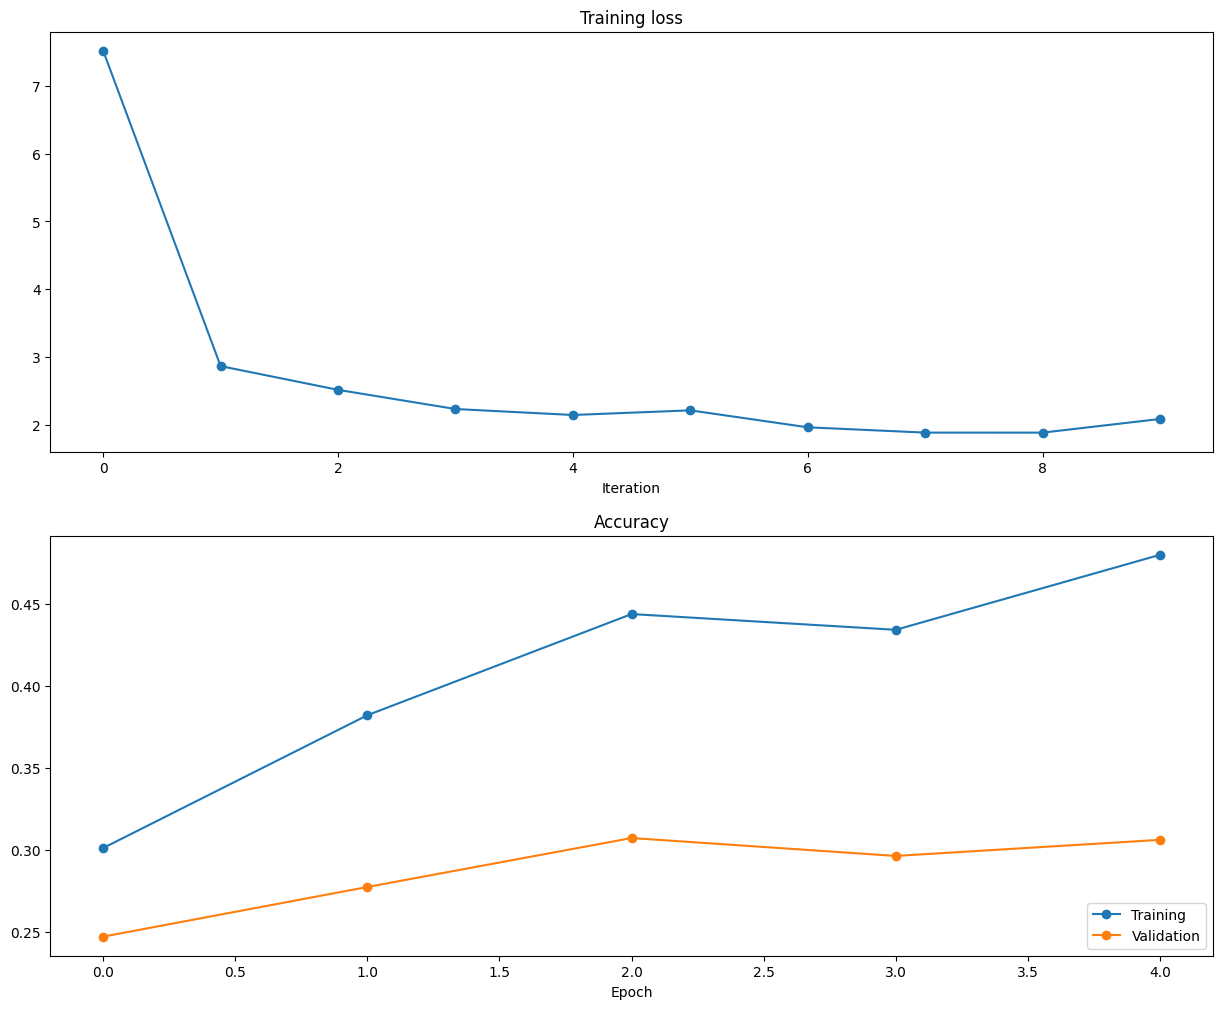

In [42]:
# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100] # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Different Optimizers and Regularization Techniques
There are several more advanced optimizers than vanilla SGD, and there are many regularization tricks. You'll implement them in this section.
Please complete the TODOs in the `lib/optim.py`.

## SGD + Weight Decay [2pt]
The update rule of SGD plus weigh decay is as shown below:  
\begin{align*}
\theta_{t+1} &= \theta_t - \eta \nabla_{\theta}J(\theta_t) - \lambda \theta_t
\end{align*}
Update the `SGD()` function in `lib/optim.py`, and also incorporate weight decay options.

In [117]:
%reload_ext autoreload

# Test the implementation of SGD with Momentum
seed = 1234
np.random.seed(seed=seed)

N, D = 4, 5
test_sgd = sequential(fc(N, D, name="sgd_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)

test_sgd.layers[0].params = {"sgd_fc_w": w}
test_sgd.layers[0].grads = {"sgd_fc_w": dw}


test_sgd_wd = SGD(test_sgd, 1e-3, 1e-4)
test_sgd_wd.step()

updated_w = test_sgd.layers[0].params["sgd_fc_w"]


expected_updated_w = np.asarray([
       [-0.39936   , -0.34678632, -0.29421263, -0.24163895, -0.18906526],
       [-0.13649158, -0.08391789, -0.03134421,  0.02122947,  0.07380316],
       [ 0.12637684,  0.17895053,  0.23152421,  0.28409789,  0.33667158],
       [ 0.38924526,  0.44181895,  0.49439263,  0.54696632,  0.59954   ]])


print ('The following errors should be around or less than 1e-6')
print ('updated_w error: ', rel_error(updated_w, expected_updated_w))

The following errors should be around or less than 1e-6
updated_w error:  8.677112905190533e-08


## Comparing SGD and SGD with Weight Decay [2pt]
Run the following code block to train a multi-layer fully connected network with both SGD and SGD plus Weight Decay.
You are expected to see Weight Decay have better validation accuracy than vinilla SGD. 

Training with Vanilla SGD...


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\basem\Projects\CSCI 566\CNN-From-Scratch\lib\mlp\layer_utils.py:257: RuntimeWarning: overflow encountered in sinh
  t3 = (np.tanh(t1)/np.sinh(t1))**2 #np.cosh(t1)**-2
  2%|▎         | 5/200 [00:00<00:04, 40.44it/s]

(Iteration 1 / 10000) Average loss: 3.3332154499786584


100%|██████████| 200/200 [00:04<00:00, 40.49it/s]


(Epoch 1 / 50) Training Accuracy: 0.15095, Validation Accuracy: 0.1474


100%|██████████| 200/200 [00:05<00:00, 39.85it/s]


(Epoch 2 / 50) Training Accuracy: 0.18815, Validation Accuracy: 0.1805


100%|██████████| 200/200 [00:05<00:00, 38.17it/s]


(Epoch 3 / 50) Training Accuracy: 0.2107, Validation Accuracy: 0.2029


100%|██████████| 200/200 [00:04<00:00, 40.53it/s]


(Epoch 4 / 50) Training Accuracy: 0.2314, Validation Accuracy: 0.212


100%|██████████| 200/200 [00:05<00:00, 38.49it/s]


(Epoch 5 / 50) Training Accuracy: 0.23915, Validation Accuracy: 0.2197


100%|██████████| 200/200 [00:05<00:00, 39.15it/s]


(Epoch 6 / 50) Training Accuracy: 0.2552, Validation Accuracy: 0.2298


100%|██████████| 200/200 [00:04<00:00, 41.43it/s]


(Epoch 7 / 50) Training Accuracy: 0.26645, Validation Accuracy: 0.2403


100%|██████████| 200/200 [00:04<00:00, 43.70it/s]


(Epoch 8 / 50) Training Accuracy: 0.27555, Validation Accuracy: 0.2414


100%|██████████| 200/200 [00:04<00:00, 42.89it/s]


(Epoch 9 / 50) Training Accuracy: 0.28185, Validation Accuracy: 0.2413


100%|██████████| 200/200 [00:04<00:00, 42.70it/s]


(Epoch 10 / 50) Training Accuracy: 0.2944, Validation Accuracy: 0.252


100%|██████████| 200/200 [00:04<00:00, 42.92it/s]


(Epoch 11 / 50) Training Accuracy: 0.29735, Validation Accuracy: 0.2543


100%|██████████| 200/200 [00:04<00:00, 42.73it/s]


(Epoch 12 / 50) Training Accuracy: 0.3021, Validation Accuracy: 0.2587


100%|██████████| 200/200 [00:04<00:00, 42.80it/s]


(Epoch 13 / 50) Training Accuracy: 0.31105, Validation Accuracy: 0.2641


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


(Epoch 14 / 50) Training Accuracy: 0.3168, Validation Accuracy: 0.2653


100%|██████████| 200/200 [00:04<00:00, 42.60it/s]


(Epoch 15 / 50) Training Accuracy: 0.3217, Validation Accuracy: 0.2681


100%|██████████| 200/200 [00:04<00:00, 43.18it/s]


(Epoch 16 / 50) Training Accuracy: 0.3307, Validation Accuracy: 0.2699


100%|██████████| 200/200 [00:04<00:00, 43.62it/s]


(Epoch 17 / 50) Training Accuracy: 0.33835, Validation Accuracy: 0.2696


100%|██████████| 200/200 [00:04<00:00, 43.07it/s]


(Epoch 18 / 50) Training Accuracy: 0.34565, Validation Accuracy: 0.2737


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


(Epoch 19 / 50) Training Accuracy: 0.3495, Validation Accuracy: 0.2729


100%|██████████| 200/200 [00:04<00:00, 43.07it/s]


(Epoch 20 / 50) Training Accuracy: 0.35565, Validation Accuracy: 0.2758


100%|██████████| 200/200 [00:04<00:00, 42.90it/s]


(Epoch 21 / 50) Training Accuracy: 0.35825, Validation Accuracy: 0.2729


100%|██████████| 200/200 [00:04<00:00, 43.06it/s]


(Epoch 22 / 50) Training Accuracy: 0.36895, Validation Accuracy: 0.278


100%|██████████| 200/200 [00:04<00:00, 43.27it/s]


(Epoch 23 / 50) Training Accuracy: 0.3734, Validation Accuracy: 0.2783


100%|██████████| 200/200 [00:04<00:00, 42.42it/s]


(Epoch 24 / 50) Training Accuracy: 0.3756, Validation Accuracy: 0.2768


100%|██████████| 200/200 [00:04<00:00, 42.88it/s]


(Epoch 25 / 50) Training Accuracy: 0.38495, Validation Accuracy: 0.278


100%|██████████| 200/200 [00:04<00:00, 43.67it/s]


(Epoch 26 / 50) Training Accuracy: 0.38415, Validation Accuracy: 0.2757


100%|██████████| 200/200 [00:04<00:00, 43.40it/s]


(Epoch 27 / 50) Training Accuracy: 0.40365, Validation Accuracy: 0.2804


100%|██████████| 200/200 [00:04<00:00, 42.56it/s]


(Epoch 28 / 50) Training Accuracy: 0.40105, Validation Accuracy: 0.2812


100%|██████████| 200/200 [00:04<00:00, 42.74it/s]


(Epoch 29 / 50) Training Accuracy: 0.40885, Validation Accuracy: 0.2773


100%|██████████| 200/200 [00:04<00:00, 43.04it/s]


(Epoch 30 / 50) Training Accuracy: 0.4163, Validation Accuracy: 0.2803


100%|██████████| 200/200 [00:04<00:00, 42.72it/s]


(Epoch 31 / 50) Training Accuracy: 0.41745, Validation Accuracy: 0.2838


100%|██████████| 200/200 [00:04<00:00, 42.75it/s]


(Epoch 32 / 50) Training Accuracy: 0.42125, Validation Accuracy: 0.2758


100%|██████████| 200/200 [00:04<00:00, 42.69it/s]


(Epoch 33 / 50) Training Accuracy: 0.433, Validation Accuracy: 0.2777


100%|██████████| 200/200 [00:04<00:00, 42.54it/s]


(Epoch 34 / 50) Training Accuracy: 0.4322, Validation Accuracy: 0.2782


100%|██████████| 200/200 [00:04<00:00, 43.03it/s]


(Epoch 35 / 50) Training Accuracy: 0.44095, Validation Accuracy: 0.2753


100%|██████████| 200/200 [00:04<00:00, 42.78it/s]


(Epoch 36 / 50) Training Accuracy: 0.4517, Validation Accuracy: 0.2783


100%|██████████| 200/200 [00:04<00:00, 42.15it/s]


(Epoch 37 / 50) Training Accuracy: 0.4583, Validation Accuracy: 0.2759


100%|██████████| 200/200 [00:04<00:00, 42.21it/s]


(Epoch 38 / 50) Training Accuracy: 0.4637, Validation Accuracy: 0.2815


100%|██████████| 200/200 [00:04<00:00, 42.30it/s]


(Epoch 39 / 50) Training Accuracy: 0.4642, Validation Accuracy: 0.2808


100%|██████████| 200/200 [00:04<00:00, 42.79it/s]


(Epoch 40 / 50) Training Accuracy: 0.47055, Validation Accuracy: 0.2784


100%|██████████| 200/200 [00:04<00:00, 42.96it/s]


(Epoch 41 / 50) Training Accuracy: 0.4684, Validation Accuracy: 0.2747


100%|██████████| 200/200 [00:04<00:00, 41.46it/s]


(Epoch 42 / 50) Training Accuracy: 0.4795, Validation Accuracy: 0.2758


100%|██████████| 200/200 [00:04<00:00, 42.35it/s]


(Epoch 43 / 50) Training Accuracy: 0.48745, Validation Accuracy: 0.2793


100%|██████████| 200/200 [00:04<00:00, 41.75it/s]


(Epoch 44 / 50) Training Accuracy: 0.49715, Validation Accuracy: 0.2751


100%|██████████| 200/200 [00:04<00:00, 43.22it/s]


(Epoch 45 / 50) Training Accuracy: 0.49545, Validation Accuracy: 0.2736


100%|██████████| 200/200 [00:04<00:00, 42.25it/s]


(Epoch 46 / 50) Training Accuracy: 0.50175, Validation Accuracy: 0.2767


100%|██████████| 200/200 [00:04<00:00, 42.97it/s]


(Epoch 47 / 50) Training Accuracy: 0.51565, Validation Accuracy: 0.2704


100%|██████████| 200/200 [00:04<00:00, 42.94it/s]


(Epoch 48 / 50) Training Accuracy: 0.51875, Validation Accuracy: 0.2786


100%|██████████| 200/200 [00:04<00:00, 42.71it/s]


(Epoch 49 / 50) Training Accuracy: 0.5235, Validation Accuracy: 0.2818


100%|██████████| 200/200 [00:04<00:00, 43.54it/s]


(Epoch 50 / 50) Training Accuracy: 0.52375, Validation Accuracy: 0.2778

Training with SGD plus Weight Decay...


  2%|▎         | 5/200 [00:00<00:04, 41.86it/s]

(Iteration 1 / 10000) Average loss: 3.3332154499786584


100%|██████████| 200/200 [00:04<00:00, 43.17it/s]


(Epoch 1 / 50) Training Accuracy: 0.148, Validation Accuracy: 0.1458


100%|██████████| 200/200 [00:04<00:00, 43.27it/s]


(Epoch 2 / 50) Training Accuracy: 0.186, Validation Accuracy: 0.1822


100%|██████████| 200/200 [00:04<00:00, 43.18it/s]


(Epoch 3 / 50) Training Accuracy: 0.2073, Validation Accuracy: 0.2027


100%|██████████| 200/200 [00:04<00:00, 43.35it/s]


(Epoch 4 / 50) Training Accuracy: 0.22575, Validation Accuracy: 0.2101


100%|██████████| 200/200 [00:04<00:00, 42.49it/s]


(Epoch 5 / 50) Training Accuracy: 0.2345, Validation Accuracy: 0.2223


100%|██████████| 200/200 [00:04<00:00, 42.97it/s]


(Epoch 6 / 50) Training Accuracy: 0.24915, Validation Accuracy: 0.2338


100%|██████████| 200/200 [00:04<00:00, 43.38it/s]


(Epoch 7 / 50) Training Accuracy: 0.2584, Validation Accuracy: 0.2451


100%|██████████| 200/200 [00:04<00:00, 42.93it/s]


(Epoch 8 / 50) Training Accuracy: 0.2651, Validation Accuracy: 0.2488


100%|██████████| 200/200 [00:04<00:00, 42.80it/s]


(Epoch 9 / 50) Training Accuracy: 0.2648, Validation Accuracy: 0.2471


100%|██████████| 200/200 [00:04<00:00, 43.00it/s]


(Epoch 10 / 50) Training Accuracy: 0.27685, Validation Accuracy: 0.2558


100%|██████████| 200/200 [00:04<00:00, 43.25it/s]


(Epoch 11 / 50) Training Accuracy: 0.2792, Validation Accuracy: 0.2583


100%|██████████| 200/200 [00:04<00:00, 43.11it/s]


(Epoch 12 / 50) Training Accuracy: 0.28575, Validation Accuracy: 0.2646


100%|██████████| 200/200 [00:04<00:00, 42.58it/s]


(Epoch 13 / 50) Training Accuracy: 0.2879, Validation Accuracy: 0.2657


100%|██████████| 200/200 [00:04<00:00, 42.79it/s]


(Epoch 14 / 50) Training Accuracy: 0.28865, Validation Accuracy: 0.2664


100%|██████████| 200/200 [00:04<00:00, 42.79it/s]


(Epoch 15 / 50) Training Accuracy: 0.29545, Validation Accuracy: 0.2705


100%|██████████| 200/200 [00:04<00:00, 42.95it/s]


(Epoch 16 / 50) Training Accuracy: 0.2964, Validation Accuracy: 0.2737


100%|██████████| 200/200 [00:04<00:00, 43.34it/s]


(Epoch 17 / 50) Training Accuracy: 0.30345, Validation Accuracy: 0.2752


100%|██████████| 200/200 [00:04<00:00, 43.29it/s]


(Epoch 18 / 50) Training Accuracy: 0.30555, Validation Accuracy: 0.276


100%|██████████| 200/200 [00:04<00:00, 43.44it/s]


(Epoch 19 / 50) Training Accuracy: 0.30715, Validation Accuracy: 0.2821


100%|██████████| 200/200 [00:04<00:00, 43.15it/s]


(Epoch 20 / 50) Training Accuracy: 0.31265, Validation Accuracy: 0.2799


100%|██████████| 200/200 [00:04<00:00, 43.89it/s]


(Epoch 21 / 50) Training Accuracy: 0.31315, Validation Accuracy: 0.2787


100%|██████████| 200/200 [00:04<00:00, 43.13it/s]


(Epoch 22 / 50) Training Accuracy: 0.31755, Validation Accuracy: 0.2836


100%|██████████| 200/200 [00:04<00:00, 43.03it/s]


(Epoch 23 / 50) Training Accuracy: 0.3192, Validation Accuracy: 0.2833


100%|██████████| 200/200 [00:04<00:00, 43.44it/s]


(Epoch 24 / 50) Training Accuracy: 0.31905, Validation Accuracy: 0.2837


100%|██████████| 200/200 [00:04<00:00, 42.67it/s]


(Epoch 25 / 50) Training Accuracy: 0.32525, Validation Accuracy: 0.2894


100%|██████████| 200/200 [00:04<00:00, 43.19it/s]


(Epoch 26 / 50) Training Accuracy: 0.3238, Validation Accuracy: 0.2895


100%|██████████| 200/200 [00:04<00:00, 44.13it/s]


(Epoch 27 / 50) Training Accuracy: 0.33645, Validation Accuracy: 0.2944


100%|██████████| 200/200 [00:04<00:00, 43.67it/s]


(Epoch 28 / 50) Training Accuracy: 0.33645, Validation Accuracy: 0.2941


100%|██████████| 200/200 [00:04<00:00, 42.98it/s]


(Epoch 29 / 50) Training Accuracy: 0.33695, Validation Accuracy: 0.2953


100%|██████████| 200/200 [00:04<00:00, 42.36it/s]


(Epoch 30 / 50) Training Accuracy: 0.3425, Validation Accuracy: 0.3


100%|██████████| 200/200 [00:04<00:00, 43.59it/s]


(Epoch 31 / 50) Training Accuracy: 0.3406, Validation Accuracy: 0.2982


100%|██████████| 200/200 [00:04<00:00, 43.24it/s]


(Epoch 32 / 50) Training Accuracy: 0.34505, Validation Accuracy: 0.2949


100%|██████████| 200/200 [00:04<00:00, 43.21it/s]


(Epoch 33 / 50) Training Accuracy: 0.34595, Validation Accuracy: 0.3011


100%|██████████| 200/200 [00:04<00:00, 43.65it/s]


(Epoch 34 / 50) Training Accuracy: 0.34755, Validation Accuracy: 0.301


100%|██████████| 200/200 [00:04<00:00, 43.00it/s]


(Epoch 35 / 50) Training Accuracy: 0.3548, Validation Accuracy: 0.3012


100%|██████████| 200/200 [00:04<00:00, 43.77it/s]


(Epoch 36 / 50) Training Accuracy: 0.3552, Validation Accuracy: 0.2995


100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


(Epoch 37 / 50) Training Accuracy: 0.35525, Validation Accuracy: 0.3034


100%|██████████| 200/200 [00:04<00:00, 43.95it/s]


(Epoch 38 / 50) Training Accuracy: 0.3593, Validation Accuracy: 0.3017


100%|██████████| 200/200 [00:04<00:00, 43.83it/s]


(Epoch 39 / 50) Training Accuracy: 0.3648, Validation Accuracy: 0.3048


100%|██████████| 200/200 [00:04<00:00, 43.53it/s]


(Epoch 40 / 50) Training Accuracy: 0.36665, Validation Accuracy: 0.311


100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


(Epoch 41 / 50) Training Accuracy: 0.35765, Validation Accuracy: 0.3068


100%|██████████| 200/200 [00:04<00:00, 43.82it/s]


(Epoch 42 / 50) Training Accuracy: 0.36375, Validation Accuracy: 0.302


100%|██████████| 200/200 [00:04<00:00, 43.18it/s]


(Epoch 43 / 50) Training Accuracy: 0.3702, Validation Accuracy: 0.3062


100%|██████████| 200/200 [00:04<00:00, 43.35it/s]


(Epoch 44 / 50) Training Accuracy: 0.37215, Validation Accuracy: 0.306


100%|██████████| 200/200 [00:04<00:00, 44.81it/s]


(Epoch 45 / 50) Training Accuracy: 0.37475, Validation Accuracy: 0.3037


100%|██████████| 200/200 [00:04<00:00, 44.41it/s]


(Epoch 46 / 50) Training Accuracy: 0.37205, Validation Accuracy: 0.3089


100%|██████████| 200/200 [00:04<00:00, 44.89it/s]


(Epoch 47 / 50) Training Accuracy: 0.3827, Validation Accuracy: 0.3097


100%|██████████| 200/200 [00:04<00:00, 45.53it/s]


(Epoch 48 / 50) Training Accuracy: 0.38395, Validation Accuracy: 0.313


100%|██████████| 200/200 [00:04<00:00, 45.16it/s]


(Epoch 49 / 50) Training Accuracy: 0.38155, Validation Accuracy: 0.3131


100%|██████████| 200/200 [00:04<00:00, 47.04it/s]


(Epoch 50 / 50) Training Accuracy: 0.38415, Validation Accuracy: 0.3121


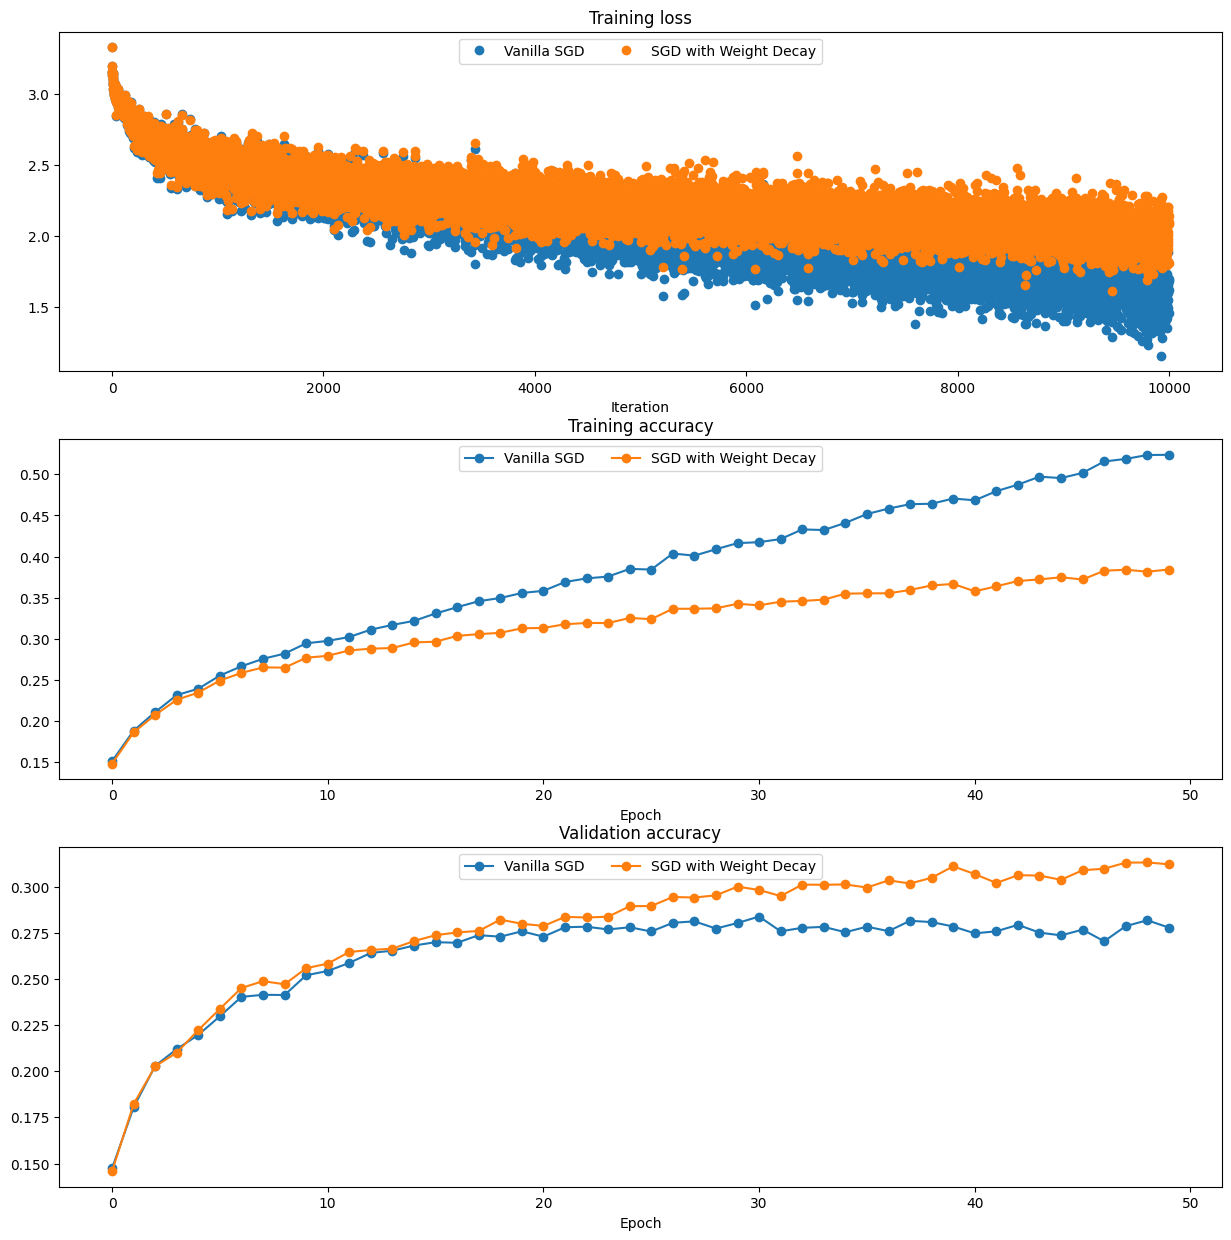

In [127]:
seed = 1234

# Arrange a small data
num_train = 20000
small_data_dict = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

reset_seed(seed=seed)
model_sgd      = FullyConnectedNetwork()
loss_f_sgd     = cross_entropy()
optimizer_sgd  = SGD(model_sgd.net, 0.01)
print ("Training with Vanilla SGD...")
results_sgd = train_net(small_data_dict, model_sgd, loss_f_sgd, optimizer_sgd, batch_size=100, 
                        max_epochs=50, show_every=10000, verbose=True)

reset_seed(seed=seed)
model_sgdw     = FullyConnectedNetwork()
loss_f_sgdw    = cross_entropy()
optimizer_sgdw = SGD(model_sgdw.net, 0.01, 1e-4)
print ("\nTraining with SGD plus Weight Decay...")
results_sgdw = train_net(small_data_dict, model_sgdw, loss_f_sgdw, optimizer_sgdw, batch_size=100, 
                         max_epochs=50, show_every=10000, verbose=True)

opt_params_sgd,  loss_hist_sgd,  train_acc_hist_sgd,  val_acc_hist_sgd  = results_sgd
opt_params_sgdw, loss_hist_sgdw, train_acc_hist_sgdw, val_acc_hist_sgdw = results_sgdw

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdw, 'o', label="SGD with Weight Decay")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdw, '-o', label="SGD with Weight Decay")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdw, '-o', label="SGD with Weight Decay")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## SGD with L1 Regularization [2pts]
With L1 Regularization, your regularized loss becomes $\tilde{J}_\mathrm{\ell_1}(\theta)$ and it's defined as
$$
\tilde{J}_\mathrm{\ell_1}(\theta) = J(\theta) + \lambda \|\theta\|_{\ell_1}
$$
where 
$$
\|\theta\|_{\ell_1} = \sum_{l=1}^n \sum_{k=1}^{n_l} |\theta_{l,k}|
$$
Please implmemt TODO block of ``apply_l1_regularization`` in ``lib/layer_utils``. Such regularization funcationality is called after gradient gathering in the ``backward`` process. 


Training with SGD plus L1 Regularization...


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\basem\Projects\CSCI 566\CNN-From-Scratch\lib\mlp\layer_utils.py:254: RuntimeWarning: overflow encountered in sinh
  t3 = (np.tanh(t1)/np.sinh(t1))**2 #np.cosh(t1)**-2
  1%|          | 2/200 [00:00<00:09, 20.00it/s]

(Iteration 1 / 10000) Average loss: 3.3332154499786584


100%|██████████| 200/200 [00:07<00:00, 27.60it/s]


(Epoch 1 / 50) Training Accuracy: 0.1491, Validation Accuracy: 0.1457


100%|██████████| 200/200 [00:05<00:00, 34.98it/s]


(Epoch 2 / 50) Training Accuracy: 0.1854, Validation Accuracy: 0.1806


100%|██████████| 200/200 [00:05<00:00, 34.56it/s]


(Epoch 3 / 50) Training Accuracy: 0.20755, Validation Accuracy: 0.2014


100%|██████████| 200/200 [00:05<00:00, 35.14it/s]


(Epoch 4 / 50) Training Accuracy: 0.22465, Validation Accuracy: 0.2111


100%|██████████| 200/200 [00:05<00:00, 33.95it/s]


(Epoch 5 / 50) Training Accuracy: 0.2331, Validation Accuracy: 0.2212


100%|██████████| 200/200 [00:06<00:00, 29.48it/s]


(Epoch 6 / 50) Training Accuracy: 0.24735, Validation Accuracy: 0.2337


100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


(Epoch 7 / 50) Training Accuracy: 0.25725, Validation Accuracy: 0.2395


100%|██████████| 200/200 [00:07<00:00, 27.87it/s]


(Epoch 8 / 50) Training Accuracy: 0.26245, Validation Accuracy: 0.2431


100%|██████████| 200/200 [00:06<00:00, 30.72it/s]


(Epoch 9 / 50) Training Accuracy: 0.26185, Validation Accuracy: 0.2449


100%|██████████| 200/200 [00:06<00:00, 30.17it/s]


(Epoch 10 / 50) Training Accuracy: 0.27205, Validation Accuracy: 0.251


100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


(Epoch 11 / 50) Training Accuracy: 0.27515, Validation Accuracy: 0.2582


100%|██████████| 200/200 [00:06<00:00, 29.66it/s]


(Epoch 12 / 50) Training Accuracy: 0.282, Validation Accuracy: 0.2606


100%|██████████| 200/200 [00:05<00:00, 33.94it/s]


(Epoch 13 / 50) Training Accuracy: 0.2838, Validation Accuracy: 0.267


100%|██████████| 200/200 [00:06<00:00, 33.22it/s]


(Epoch 14 / 50) Training Accuracy: 0.28535, Validation Accuracy: 0.2645


100%|██████████| 200/200 [00:06<00:00, 32.25it/s]


(Epoch 15 / 50) Training Accuracy: 0.2883, Validation Accuracy: 0.2655


100%|██████████| 200/200 [00:05<00:00, 33.50it/s]


(Epoch 16 / 50) Training Accuracy: 0.2926, Validation Accuracy: 0.2676


100%|██████████| 200/200 [00:05<00:00, 33.47it/s]


(Epoch 17 / 50) Training Accuracy: 0.296, Validation Accuracy: 0.2742


100%|██████████| 200/200 [00:05<00:00, 34.37it/s]


(Epoch 18 / 50) Training Accuracy: 0.2991, Validation Accuracy: 0.2715


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


(Epoch 19 / 50) Training Accuracy: 0.30085, Validation Accuracy: 0.2734


100%|██████████| 200/200 [00:06<00:00, 32.26it/s]


(Epoch 20 / 50) Training Accuracy: 0.30465, Validation Accuracy: 0.2756


100%|██████████| 200/200 [00:07<00:00, 26.69it/s]


(Epoch 21 / 50) Training Accuracy: 0.30195, Validation Accuracy: 0.271


100%|██████████| 200/200 [00:07<00:00, 26.37it/s]


(Epoch 22 / 50) Training Accuracy: 0.3069, Validation Accuracy: 0.2785


100%|██████████| 200/200 [00:07<00:00, 26.95it/s]


(Epoch 23 / 50) Training Accuracy: 0.30985, Validation Accuracy: 0.2776


100%|██████████| 200/200 [00:06<00:00, 30.40it/s]


(Epoch 24 / 50) Training Accuracy: 0.30745, Validation Accuracy: 0.2768


100%|██████████| 200/200 [00:06<00:00, 30.85it/s]


(Epoch 25 / 50) Training Accuracy: 0.3103, Validation Accuracy: 0.2814


100%|██████████| 200/200 [00:06<00:00, 31.38it/s]


(Epoch 26 / 50) Training Accuracy: 0.3091, Validation Accuracy: 0.2778


100%|██████████| 200/200 [00:06<00:00, 31.09it/s]


(Epoch 27 / 50) Training Accuracy: 0.31465, Validation Accuracy: 0.2853


100%|██████████| 200/200 [00:06<00:00, 31.05it/s]


(Epoch 28 / 50) Training Accuracy: 0.31695, Validation Accuracy: 0.2851


100%|██████████| 200/200 [00:06<00:00, 31.59it/s]


(Epoch 29 / 50) Training Accuracy: 0.3157, Validation Accuracy: 0.2819


100%|██████████| 200/200 [00:05<00:00, 33.50it/s]


(Epoch 30 / 50) Training Accuracy: 0.31705, Validation Accuracy: 0.2901


100%|██████████| 200/200 [00:06<00:00, 30.44it/s]


(Epoch 31 / 50) Training Accuracy: 0.3152, Validation Accuracy: 0.2835


100%|██████████| 200/200 [00:06<00:00, 32.64it/s]


(Epoch 32 / 50) Training Accuracy: 0.3168, Validation Accuracy: 0.2843


100%|██████████| 200/200 [00:05<00:00, 33.88it/s]


(Epoch 33 / 50) Training Accuracy: 0.31745, Validation Accuracy: 0.2843


100%|██████████| 200/200 [00:05<00:00, 33.72it/s]


(Epoch 34 / 50) Training Accuracy: 0.31705, Validation Accuracy: 0.2855


100%|██████████| 200/200 [00:06<00:00, 31.61it/s]


(Epoch 35 / 50) Training Accuracy: 0.32255, Validation Accuracy: 0.287


100%|██████████| 200/200 [00:06<00:00, 32.13it/s]


(Epoch 36 / 50) Training Accuracy: 0.3215, Validation Accuracy: 0.2873


100%|██████████| 200/200 [00:06<00:00, 32.77it/s]


(Epoch 37 / 50) Training Accuracy: 0.32235, Validation Accuracy: 0.2887


100%|██████████| 200/200 [00:05<00:00, 33.46it/s]


(Epoch 38 / 50) Training Accuracy: 0.3196, Validation Accuracy: 0.2845


100%|██████████| 200/200 [00:06<00:00, 33.25it/s]


(Epoch 39 / 50) Training Accuracy: 0.32645, Validation Accuracy: 0.2928


100%|██████████| 200/200 [00:06<00:00, 30.78it/s]


(Epoch 40 / 50) Training Accuracy: 0.32535, Validation Accuracy: 0.2926


100%|██████████| 200/200 [00:06<00:00, 32.02it/s]


(Epoch 41 / 50) Training Accuracy: 0.3185, Validation Accuracy: 0.2867


100%|██████████| 200/200 [00:05<00:00, 33.48it/s]


(Epoch 42 / 50) Training Accuracy: 0.3197, Validation Accuracy: 0.2841


100%|██████████| 200/200 [00:06<00:00, 31.29it/s]


(Epoch 43 / 50) Training Accuracy: 0.32515, Validation Accuracy: 0.2906


100%|██████████| 200/200 [00:06<00:00, 31.84it/s]


(Epoch 44 / 50) Training Accuracy: 0.3239, Validation Accuracy: 0.2868


100%|██████████| 200/200 [00:06<00:00, 32.59it/s]


(Epoch 45 / 50) Training Accuracy: 0.32375, Validation Accuracy: 0.2884


100%|██████████| 200/200 [00:06<00:00, 33.09it/s]


(Epoch 46 / 50) Training Accuracy: 0.3223, Validation Accuracy: 0.289


100%|██████████| 200/200 [00:06<00:00, 31.49it/s]


(Epoch 47 / 50) Training Accuracy: 0.32585, Validation Accuracy: 0.2897


100%|██████████| 200/200 [00:06<00:00, 32.17it/s]


(Epoch 48 / 50) Training Accuracy: 0.3282, Validation Accuracy: 0.2927


100%|██████████| 200/200 [00:06<00:00, 29.80it/s]


(Epoch 49 / 50) Training Accuracy: 0.3257, Validation Accuracy: 0.2916


100%|██████████| 200/200 [00:06<00:00, 31.87it/s]


(Epoch 50 / 50) Training Accuracy: 0.32625, Validation Accuracy: 0.2915


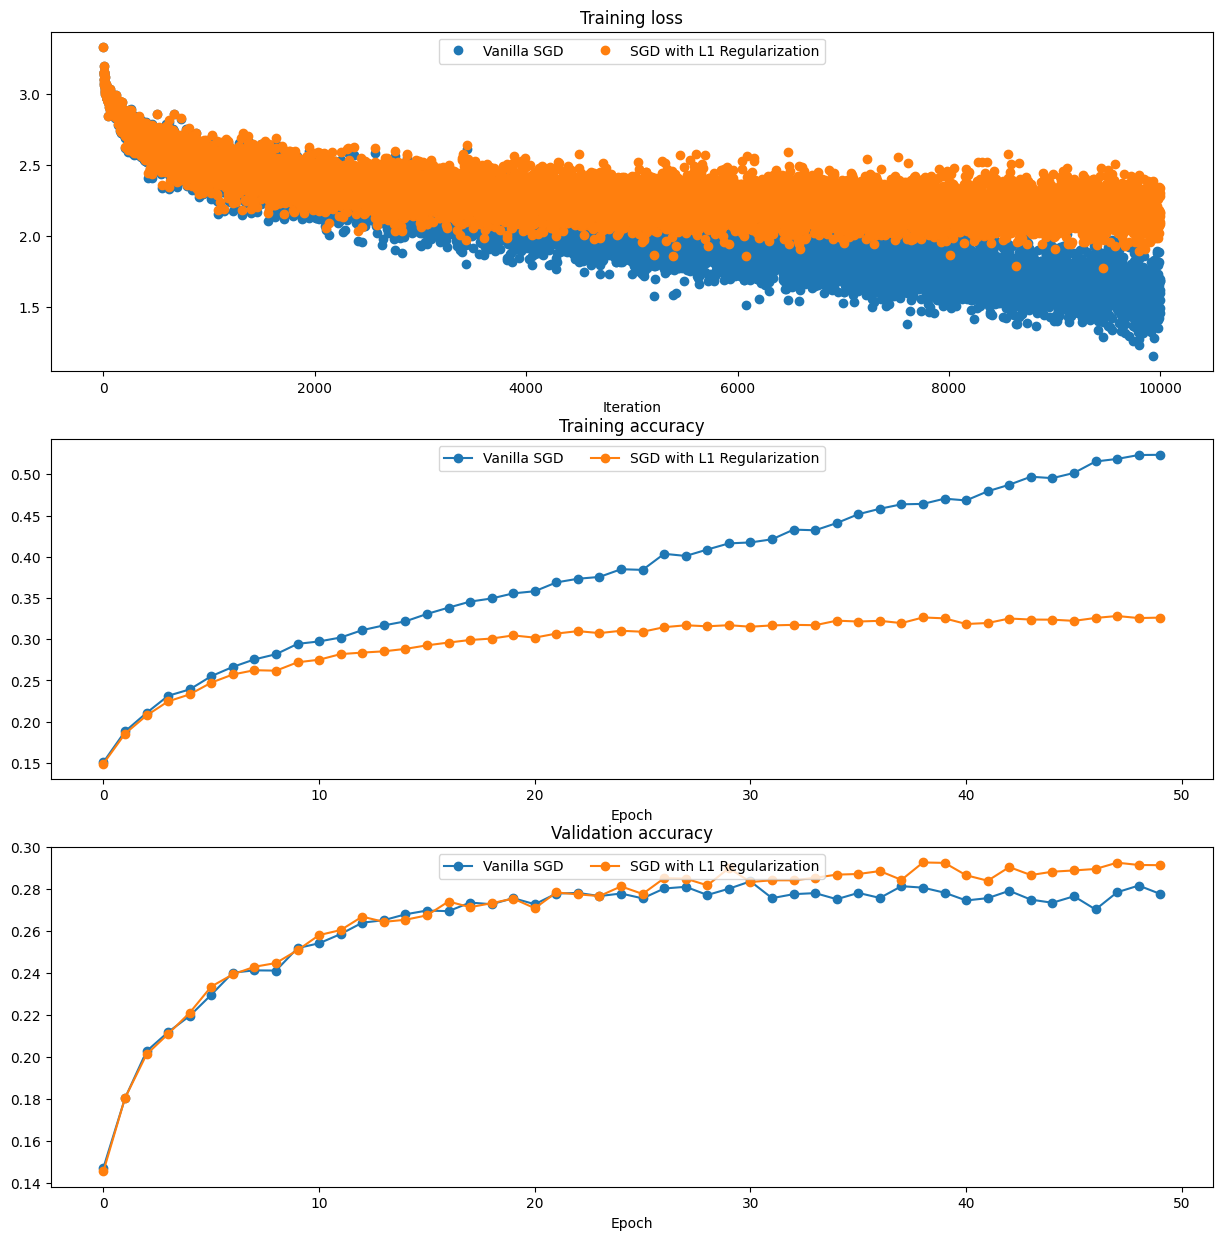

In [74]:
reset_seed(seed=seed)
model_sgd_l1     = FullyConnectedNetwork()
loss_f_sgd_l1    = cross_entropy()
optimizer_sgd_l1 = SGD(model_sgd_l1.net, 0.01)

print ("\nTraining with SGD plus L1 Regularization...")
results_sgd_l1 = train_net(small_data_dict, model_sgd_l1, loss_f_sgd_l1, optimizer_sgd_l1, batch_size=100, 
                         max_epochs=50, show_every=10000, verbose=True, regularization="l1", reg_lambda=1e-3)

opt_params_sgd_l1, loss_hist_sgd_l1, train_acc_hist_sgd_l1, val_acc_hist_sgd_l1= results_sgd_l1

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd_l1, 'o', label="SGD with L1 Regularization")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd_l1, '-o', label="SGD with L1 Regularization")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd_l1, '-o', label="SGD with L1 Regularization")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## SGD with L2 Regularization [2pts]
With L2 Regularization, your regularized loss becomes $\tilde{J}_\mathrm{\ell_2}(\theta)$ and it's defined as
$$
\tilde{J}_\mathrm{\ell_2}(\theta) = J(\theta) + \lambda \|\theta\|_{\ell_2}^2
$$
where 
$$
\|\theta\|_{\ell_2}^2 = \sum_{l=1}^n \sum_{k=1}^{n_l} \theta_{l,k}^2
$$
Similarly, implmemt TODO block of ``apply_l2_regularization`` in ``lib/layer_utils``.
For SGD, you're also asked to find the $\lambda$ for L2 Regularization such that it achives the EXACTLY SAME effect as weight decay in the previous cells. As a reminder, learning rate is the same as previously, and the weight decay paramter was 1e-4.


Training with SGD plus L2 Regularization...


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\basem\Projects\CSCI 566\CNN-From-Scratch\lib\mlp\layer_utils.py:254: RuntimeWarning: overflow encountered in sinh
  t1 = np.sqrt(2 / np.pi) * (feat + 0.044715 * feat**3)
100%|██████████| 200/200 [00:05<00:00, 35.65it/s]


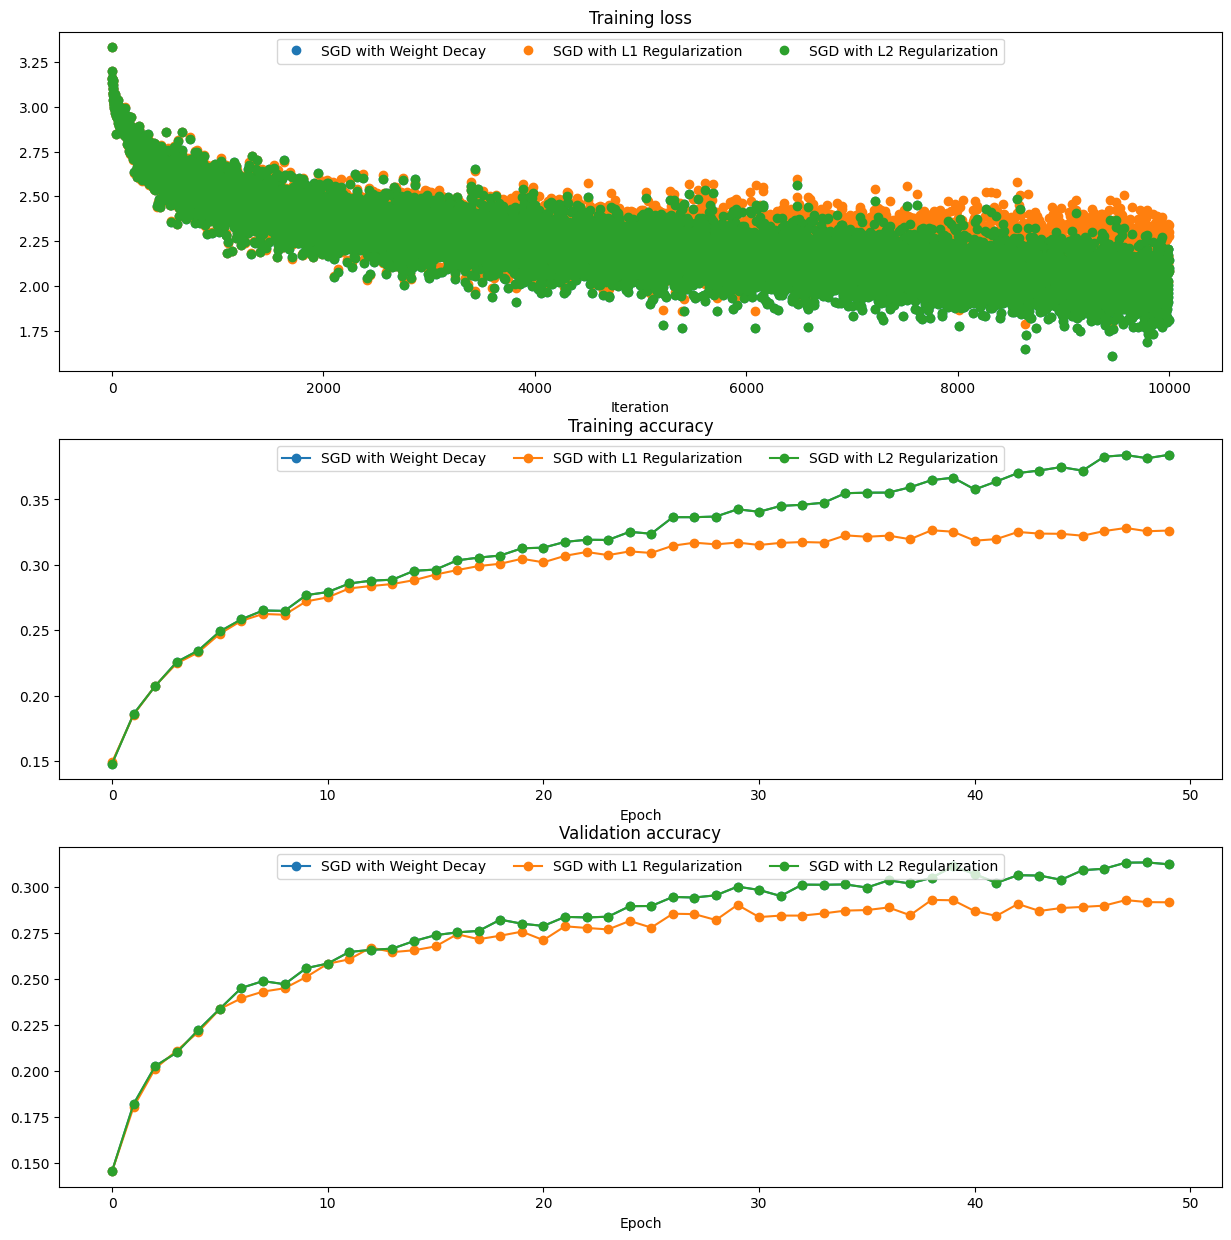

In [128]:
reset_seed(seed=seed)
model_sgd_l2     = FullyConnectedNetwork()
loss_f_sgd_l2    = cross_entropy()
optimizer_sgd_l2 = SGD(model_sgd_l2.net, 0.01)
#####################################################################
#### Find lambda for L2 regularization so that                   ####
#### it achieves EXACTLY THE SAME learning curve as weight decay ####
# l2_lambda = -1*(1e-4)/2
lr, weight_decay = 0.01, 1e-4
l2_lambda = weight_decay/(2*lr)
#####################################################################

print ("\nTraining with SGD plus L2 Regularization...")
results_sgd_l2 = train_net(small_data_dict, model_sgd_l2, loss_f_sgd_l2, optimizer_sgd_l2, batch_size=100, 
                           max_epochs=50, show_every=10000, verbose=False, regularization="l2", reg_lambda=l2_lambda)

opt_params_sgd_l2, loss_hist_sgd_l2, train_acc_hist_sgd_l2, val_acc_hist_sgd_l2 = results_sgd_l2

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdw, 'o', label="SGD with Weight Decay")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdw, '-o', label="SGD with Weight Decay")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdw, '-o', label="SGD with Weight Decay")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd_l1, 'o', label="SGD with L1 Regularization")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd_l1, '-o', label="SGD with L1 Regularization")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd_l1, '-o', label="SGD with L1 Regularization")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd_l2, 'o', label="SGD with L2 Regularization")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd_l2, '-o', label="SGD with L2 Regularization")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd_l2, '-o', label="SGD with L2 Regularization")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Adam [2pt]
The update rule of Adam is as shown below:  
\begin{align*}
t &= t + 1 \\
g_t &: \text{gradients at update step } t \\
m_t &= \beta_1m_{t-1} + (1-\beta_1)g_t \\
v_t &= \beta_2v_{t-1} + (1-\beta_2)g_t^2 \\
\hat{m_t} &= m_t / (1 - \beta_1^t) \\
\hat{v_t} &= v_t / (1 - \beta_2^t) \\
\theta_{t+1} &= \theta_t - \frac{\eta\ \hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon} \\
\end{align*}
Complete the `Adam()` function in `lib/optim.py`
Important Notes:
1) $t$ must be updated before everything else
2) $\beta_1^t$ is $\beta_1$ exponentiated to the $t$'th power
3) You should also enable weight decay in Adam, similar to what you did in SGD

In [132]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

# Test Adam implementation; you should see errors around 1e-7 or less
N, D = 4, 5
test_adam = sequential(fc(N, D, name="adam_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

test_adam.layers[0].params = {"adam_fc_w": w}
test_adam.layers[0].grads = {"adam_fc_w": dw}

opt_adam = Adam(test_adam, 1e-2, 0.9, 0.999, t=5)
opt_adam.mt = {"adam_fc_w": m}
opt_adam.vt = {"adam_fc_w": v}
opt_adam.step()

updated_w = test_adam.layers[0].params["adam_fc_w"]
mt = opt_adam.mt["adam_fc_w"]
vt = opt_adam.vt["adam_fc_w"]

expected_updated_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print ('The following errors should be around or less than 1e-7')
print ('updated_w error: ', rel_error(expected_updated_w, updated_w))
print ('mt error: ', rel_error(expected_m, mt))
print ('vt error: ', rel_error(expected_v, vt))

The following errors should be around or less than 1e-7
updated_w error:  1.1395691798535431e-07
mt error:  4.214963193114416e-09
vt error:  4.208314038113071e-09


## Comparing the Weight Decay v.s. L2 Regularization in Adam [5pt]
Run the following code block to compare the plotted results between effects of weight decay and L2 regularization on Adam. Are they still the same? (we can make them the same as in SGD, can we also do it in Adam?)

Training with AdamW...


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\basem\Projects\CSCI 566\CNN-From-Scratch\lib\mlp\layer_utils.py:254: RuntimeWarning: overflow encountered in sinh
  t1 = np.sqrt(2 / np.pi) * (feat + 0.044715 * feat**3)
100%|██████████| 200/200 [00:07<00:00, 27.54it/s]



Training with Adam + L2...


100%|██████████| 200/200 [00:07<00:00, 26.26it/s]


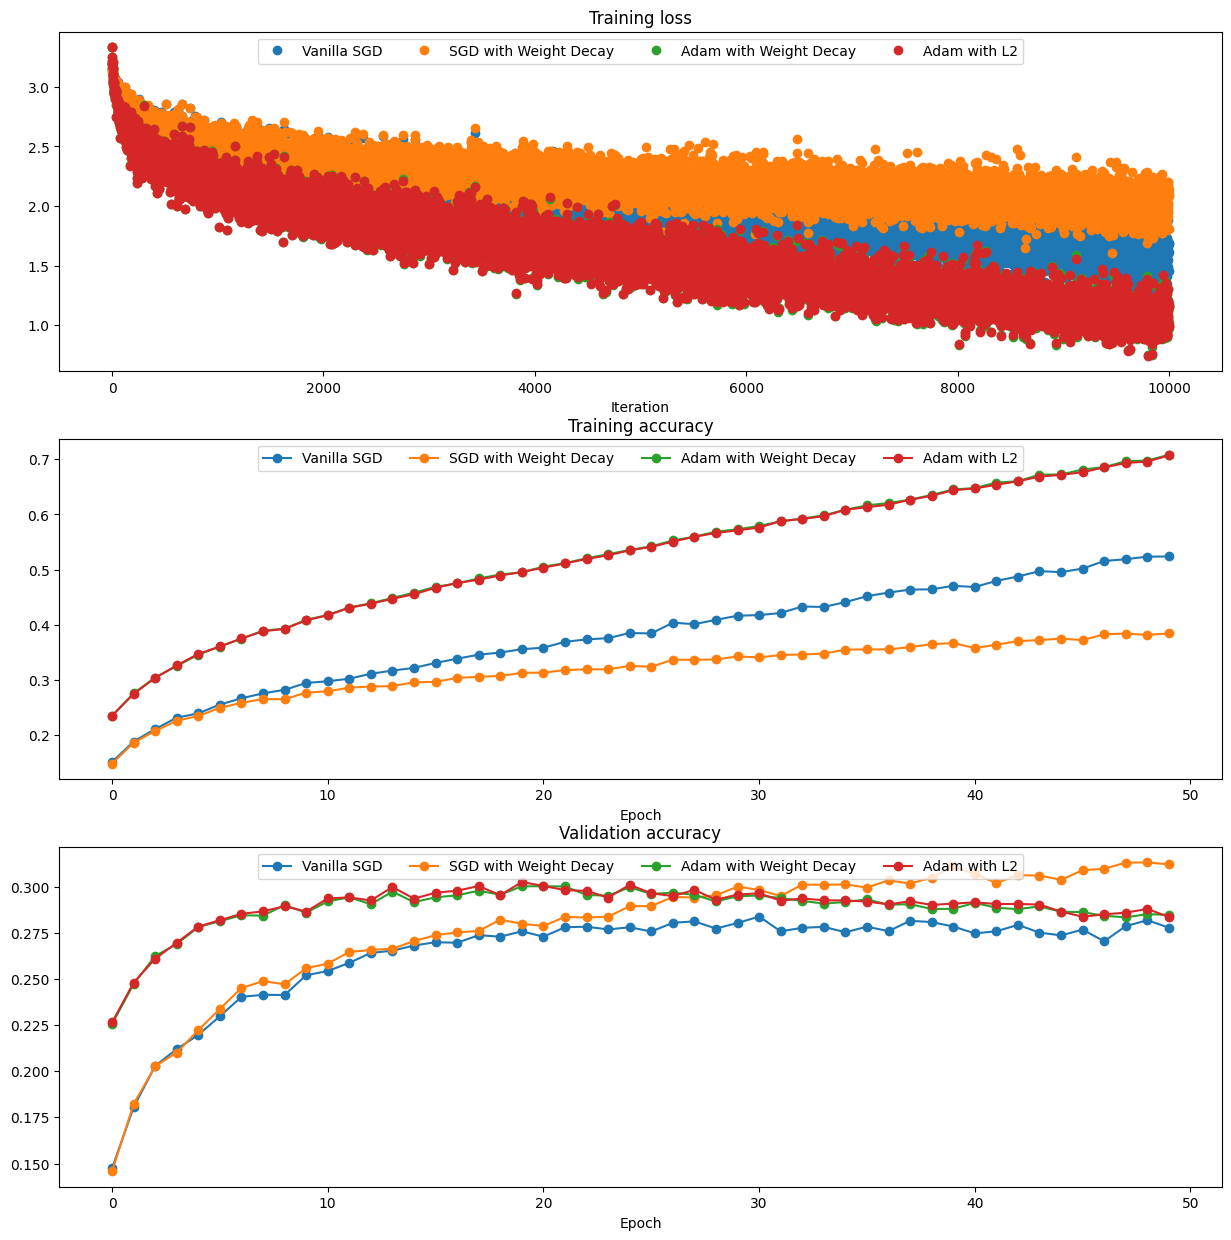

In [133]:
seed = 1234
reset_seed(seed)
model_adam_wd      = FullyConnectedNetwork()
loss_f_adam_wd     = cross_entropy()
optimizer_adam_wd  = Adam(model_adam_wd.net, lr=1e-4, weight_decay=1e-6)


print ("Training with AdamW...")
results_adam_wd = train_net(small_data_dict, model_adam_wd, loss_f_adam_wd, optimizer_adam_wd, batch_size=100, 
                        max_epochs=50, show_every=10000, verbose=False)

reset_seed(seed)
model_adam_l2      = FullyConnectedNetwork()
loss_f_adam_l2     = cross_entropy()
optimizer_adam_l2 = Adam(model_adam_l2.net, lr=1e-4)
reg_lambda_l2 = 1e-4
print ("\nTraining with Adam + L2...")
results_adam_l2 = train_net(small_data_dict, model_adam_l2, loss_f_adam_l2, optimizer_adam_l2, batch_size=100, 
                         max_epochs=50, show_every=10000, verbose=False, regularization='l2', reg_lambda=reg_lambda_l2)

opt_params_adam_wd, loss_hist_adam_wd, train_acc_hist_adam_wd, val_acc_hist_adam_wd  = results_adam_wd
opt_params_adam_l2, loss_hist_adam_l2, train_acc_hist_adam_l2, val_acc_hist_adam_l2 = results_adam_l2

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdw, 'o', label="SGD with Weight Decay")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdw, '-o', label="SGD with Weight Decay")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdw, '-o', label="SGD with Weight Decay")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_adam_wd, 'o', label="Adam with Weight Decay")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_adam_wd, '-o', label="Adam with Weight Decay")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_adam_wd, '-o', label="Adam with Weight Decay")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_adam_l2, 'o', label="Adam with L2")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_adam_l2, '-o', label="Adam with L2")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_adam_l2, '-o', label="Adam with L2")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Submission

Please prepare a PDF document `problem_1_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for the simple neural network training with > 30% validation accuracy
2. Plots for comparing vanilla SGD to SGD + Weight Decay, SGD + L1 and SGD + L2
3. "Comparing different Regularizations with Adam" plots

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.